# LeafScans WorkBook 1:
In this notebook:  
* Load Nutrient and Gas Ex scans
* Load Nute and Gas Ex targets  
* Merge scans and targets  
* Create summary stats and graphs of data  

In [1]:
# load libraries
import pandas as pd
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

## Load Scans and nutes

In [2]:
df_nutes = pd.read_csv(r'../Data/NuteScansAll_merged.csv')
df_gasex = pd.read_csv(r'../Data/GasExScansAll_Merged.csv')
df_gasex_scans = pd.read_csv(r'../Data/GasEx_WiDiv2022_scans.csv')
df_gasex_targets = pd.read_csv(r'../Data/GasEx_WiDiv2022_targets.csv')

In [3]:
print(df_nutes.columns)
print(df_gasex_scans.columns)
print(df_gasex_targets.columns)

Index(['OriginalID', 'Year', 'Flag', 'Field', 'DateSampled', 'Plot', 'Hybrid',
       'DevStage', 'LeafSampled', 'Treatment1',
       ...
       '925', '926', '928', '929', '930', '932', '933', '934', '936', '937'],
      dtype='object', length=395)
Index(['scanTime', 'Plot', 'Plant', 'ndvi', 'area', 'length', 'width', '453',
       '455', '456',
       ...
       '925', '926', '928', '929', '930', '932', '933', '934', '936', '937'],
      dtype='object', length=371)
Index(['Plot', 'Name', 'Ntreatment', 'E', 'A', 'Ci', 'gsw', 'WUE'], dtype='object')


In [ ]:
####### Merge and save GasEx scans with targets - Retired to laod merge file ##########
# Group scans by plot and average scans
#df_gasex_scans.drop(['scanTime', 'Plant'], axis=1, inplace=True)
#df_gasex = df_gasex_scans.groupby(by = 'Plot').mean()
# Merge Gasex scans with targets
#df_gasex = pd.merge(df_gasex_targets, df_gasex, on = 'Plot')
# Gasex merged looks pretty good here in data viewer, lets save
#df_gasex.to_csv(r'../Data/GasExScansAll_Merged.csv', index=False)

## Create Summary Stats and Graphs
* filler

In [4]:
# Wavelengths lilst usefule for graphing and looping
wavelengths = df_gasex.columns[20:].astype(str)

In [5]:
# Graph of savgol vs normal
df_gasex_sav = savgol_filter(df_gasex[wavelengths].values, window_length= 20, polyorder=3)
df_gasex_nosav = df_gasex[wavelengths].values
df_nutes_nosav = df_nutes[wavelengths].values

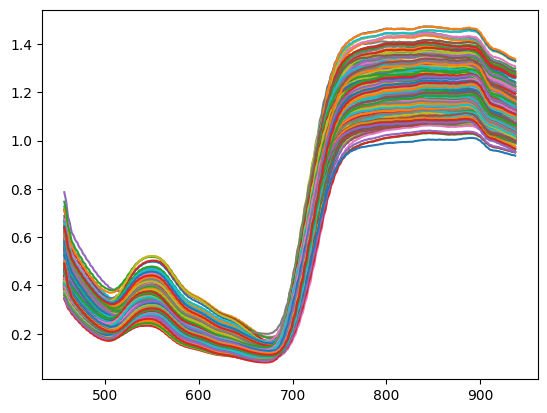

In [6]:
plt.plot(wavelengths.astype(int), df_nutes_nosav.T)
plt.show()

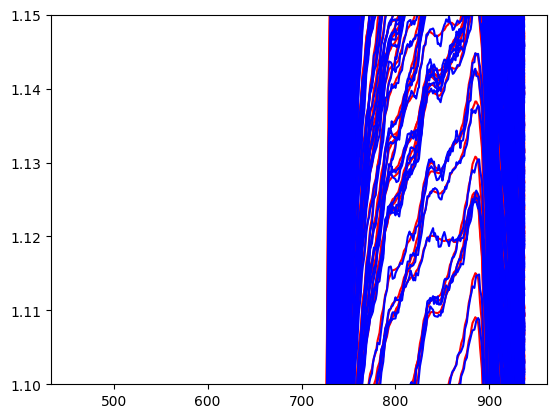

In [7]:
plt.plot(wavelengths.astype(int), df_gasex_sav.T, color = 'red')
plt.plot(wavelengths.astype(int), df_gasex_nosav.T, color = 'blue')
plt.ylim([1.1, 1.15])
plt.show()

In [ ]:
df_gasex_sav[1].T

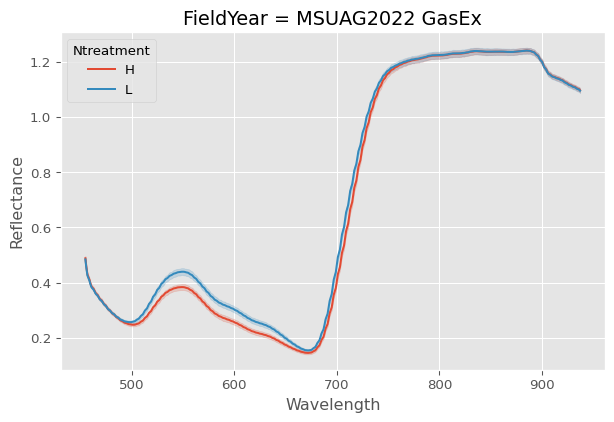

In [5]:
dfmelt = df_gasex.melt(id_vars=['Plot', 'Name', 'Ntreatment'],
                 value_vars=wavelengths, value_name = 'Reflectance', var_name='Wavelength')
dfmelt['Wavelength'] = dfmelt['Wavelength'].astype(int)


fig = plt.figure(figsize=(6.5, 4.5), dpi=96)
with plt.style.context('ggplot'):
    sns.lineplot(data=dfmelt, x='Wavelength', y='Reflectance', hue='Ntreatment', errorbar =('ci', 95))
    plt.title('FieldYear = MSUAG2022 GasEx')
    plt.tight_layout()
    plt.show()

In [6]:
df_nutes['Year'] = df_nutes['Year'].astype('str')
df_nutes['FieldYear'] = df_nutes['Field'] + df_nutes['Year']
#df_nutes = df_nutes[df_nutes['Field'] == 'MSUAG']
dfmelt = df_nutes.melt(id_vars=['Plot', 'Treatment1', 'FieldYear'],
                 value_vars=wavelengths, value_name = 'Reflectance', var_name='Wavelength')

dfmelt['Wavelength'] = dfmelt['Wavelength'].astype(int)

<Figure size 576x384 with 0 Axes>

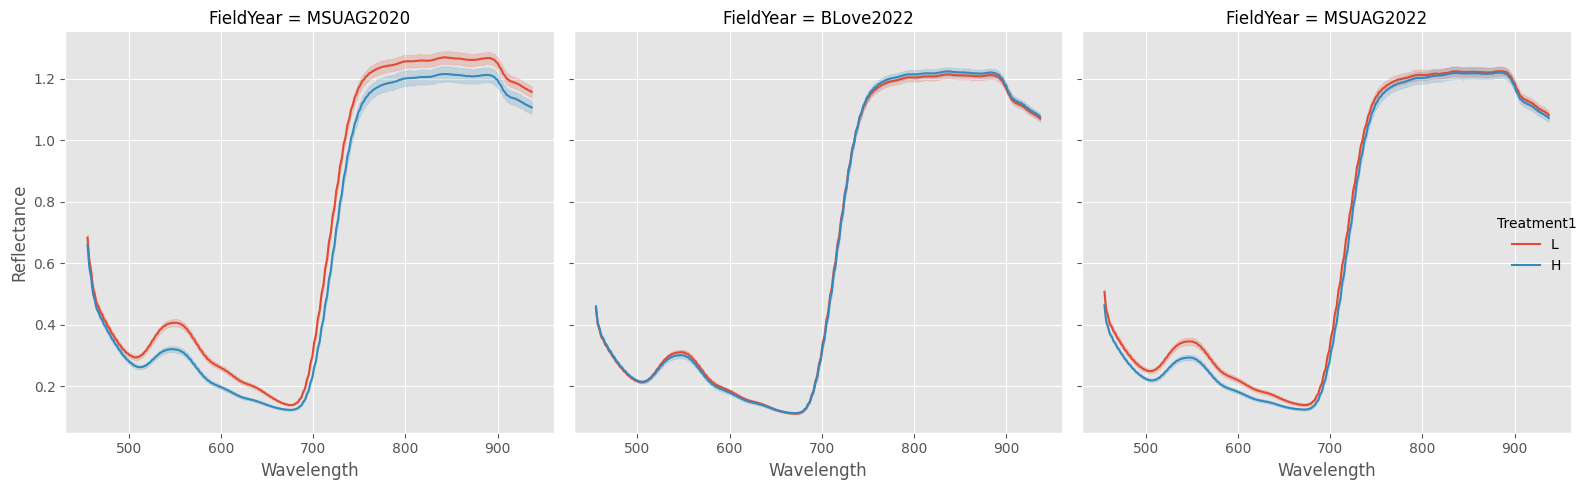

In [7]:
fig = plt.figure(figsize=(6, 4), dpi=96)
with plt.style.context('ggplot'):
    sns.relplot(data=dfmelt, x='Wavelength', y='Reflectance', hue='Treatment1', col = 'FieldYear',
                kind = 'line', errorbar =('ci', 95))
    plt.tight_layout()
    plt.show()

## Summary stats
* Calc NDVI and PCA components then make corr heatmap of them plus traits for gas ex and then 

In [8]:
# Calculate NDVI based on lit
df_gasex['ndvi'] = (df_gasex['800'] - df_gasex['651'])/(df_gasex['800'] + df_gasex['651'])

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [10]:
# Scale the spectra
scaler = StandardScaler()
scaled_spec = scaler.fit_transform(df_gasex[wavelengths])

In [11]:
# Calculate components for scaled spectra
pca = PCA(n_components=5)
pca_components = pca.fit_transform(scaled_spec)
ev= pca.explained_variance_ratio_
print(np.cumsum(ev))
# Create df for components
pca_df = pd.DataFrame(data = pca_components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# attach components back to gas_ex
print(pca_df.shape)
print(df_gasex.shape)
df_gasex_pca = pd.concat([df_gasex, pca_df], axis = 1)

[0.63232076 0.92062481 0.98744981 0.99509403 0.99758413]
(213, 5)
(213, 381)


In [12]:

print(df_gasex_pca.shape)
fig = px.scatter(df_gasex, x = 'PC1', y = 'PC2', color = 'Ntreatment',
                 width=500, height=300, title= 'PC1 and PC2 Loadings - Diversity Panel')
fig.show()

(213, 386)


<Axes: >

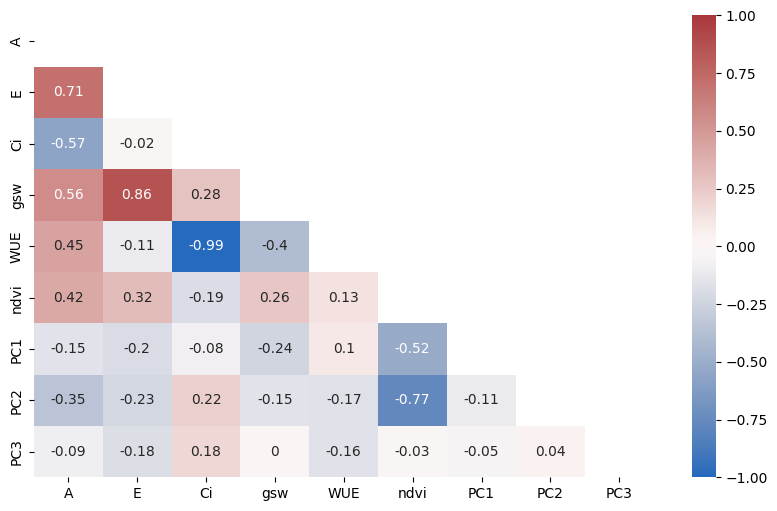

In [27]:
# make our corr heat map
# Create corr heat map between ndvi and gas ex
df_corr = df_gasex.loc[:, ['A', 'E', 'Ci', 'gsw', 'WUE', 'ndvi', 'PC1', 'PC2', 'PC3']]
df_corr = df_corr.corr().round(2)
matrix = np.triu(np.ones_like(df_corr))
plt.figure(figsize=(10,6))
sns.heatmap(df_corr, annot=True, mask = matrix, vmin = -1, vmax =1, cmap = 'vlag')

In [13]:
# Summary stats for nutes
# Calculate NDVI based on lit
df_nutes['ndvi'] = (df_nutes['800'] - df_nutes['651'])/(df_nutes['800'] + df_nutes['651'])
# Use just R2
df_nutes_R2 = df_nutes[df_nutes['DevStage'] == 'R2'].reset_index()
# Scale the spectra
scaler = StandardScaler()
scaled_spec = scaler.fit_transform(df_nutes_R2[wavelengths])
# Calculate components for scalled spectra
pca = PCA(n_components=5)
pca_components = pca.fit_transform(scaled_spec)
ev= pca.explained_variance_ratio_
print(np.cumsum(ev))
# Create df for components
pca_df = pd.DataFrame(data = pca_components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# attach components back to gas_ex
print(pca_df.shape)
print(df_nutes_R2.shape)
df_nutes_pca = pd.concat([df_nutes_R2, pca_df], axis = 1)
print(df_nutes_pca.shape)
fig = px.scatter(df_nutes_R2, x = 'PC1', y = 'PC2', color = 'Treatment1',
                 width=500, height=300, title= 'PC1 and PC2 Loadings - Hybrid Panel')
fig.show()


[0.77448074 0.90695637 0.9812489  0.99661836 0.99850622]
(174, 5)
(174, 396)
(174, 401)


In [14]:
print(df_nutes_pca.columns[17:28])
nutes = list(df_nutes_pca.columns[17:28])
col2keep = nutes + ['ndvi', 'PC1', 'PC2', 'PC3']

Index(['length', 'width', 'N', 'P', 'K', 'Ca', 'Mg', 'Na', 'S', 'Zn', 'Mn'], dtype='object')


<Axes: >

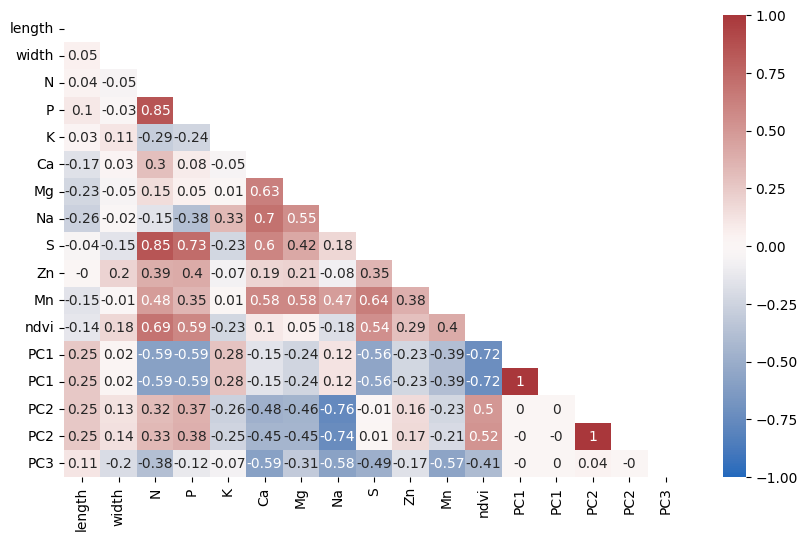

In [15]:
# make our corr heat map
# Create corr heat map between ndvi and gas ex
df_corr = df_nutes_pca.loc[:, col2keep]
df_corr = df_corr.corr().round(2)
matrix = np.triu(np.ones_like(df_corr))
plt.figure(figsize=(10,6))
sns.heatmap(df_corr, annot=True, mask = matrix, vmin = -1, vmax =1, cmap = 'vlag')

In [47]:
df_gasex_pca.to_clipboard()

In [14]:
df_nutes_pca.to_clipboard()